In [1]:
%matplotlib inline

import os
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn import linear_model as lm
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
os.chdir("..")

In [3]:
import API.crunching as cr
import API.model_testing as mt

In [4]:
df = pd.read_csv("data/mower_market_datasets/mower_market_snapshot.csv", sep=";")

In [5]:
df = cr.clean_df(df)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [7]:
df.shape

(1330, 13)

In [8]:
train_col =  list(filter(lambda x : x not in ['index', 'id', 'market_share', 'attractiveness'], df.columns))
target_col = 'attractiveness'

In [9]:
model = sk.linear_model.Ridge()

In [10]:
RMSLE = mt.eval_model(df, model)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [11]:
RMSLE

0.004341081634104302

In [11]:
train_col =  list(filter(lambda x : x not in ['index', 'id', 'market_share', 'attractiveness', 'margin'], df.columns))

In [12]:
RMSLE = mt.eval_model(df, model, train_col=train_col)

In [13]:
RMSLE

0.004412890168990614

In [14]:
nb_iter, RMSLE_vec = [], []
for i in range(1000, 20000, 1000):
    model = sk.linear_model.Ridge(max_iter=i)
    RMSLE = mt.eval_model(df, model, train_col=train_col)
    nb_iter.append(i)
    RMSLE_vec.append(RMSLE)

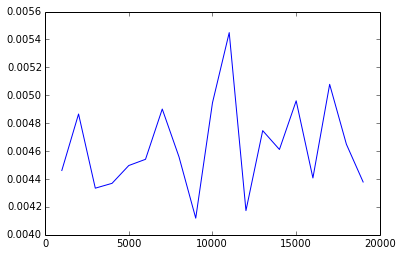

In [15]:
plt.plot(np.array(nb_iter), np.array(RMSLE_vec))

In [16]:
alphas, RMSLE_vec = [], []
for i in np.arange(0.0, 1, 0.1):
    model = sk.linear_model.Ridge(alpha=i)
    RMSLE = mt.eval_model(df, model, train_col=train_col)
    alphas.append(i)
    RMSLE_vec.append(RMSLE)

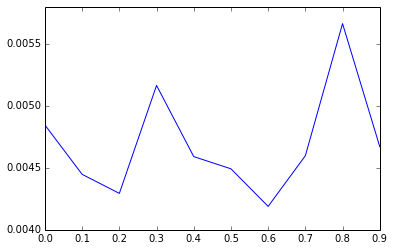

In [17]:
plt.plot(np.array(alphas), np.array(RMSLE_vec))

In [31]:
train_col =  list(filter(lambda x : x not in ['index', 'id', 'market_share', 'attractiveness'], df.columns))
target_col = 'attractiveness'

In [34]:
model = sk.linear_model.Ridge()

In [38]:
model

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
RMSLE = mt.eval_model(df, model, train_col=train_col)

In [19]:
mt.save_model(df, train_col, target_col, model, path='data/')

In [12]:
sub = pd.read_csv("Data/mower_market_datasets/submission_set.csv", sep=";")

In [13]:
sub = cr.clean_df(sub)

In [14]:
#train_col =  list(filter(lambda x : x not in ['index', 'id', 'market_share', 'margin'], df.columns))
sub = sub[train_col]

In [34]:
np.exp(max(model.predict(sub)))-1

0.9804722334924751

In [15]:
sub['attractiveness_pred'] = np.exp(model.predict(sub))-1

In [17]:
sub.to_csv('data/DF/submission.csv', index=False)

In [52]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

In [86]:
import sklearn.preprocessing as prepo

In [87]:
scaler = prepo.StandardScaler()

In [38]:
features = df[train_col]
labels = df['attractiveness']

In [91]:
f = scaler.fit_transform(features)

In [39]:
features.shape

(1330, 9)

In [147]:
def simple_nn(model_input_shape):
    
    # Input_layer
    X_input = Input(shape = (model_input_shape[1], ))

    # Dense Layer
    X = Dense(2)(X_input)

    # Dense Layer2
    X = Dense(1)(X)
    
    # Model definition
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [151]:
def simple_nn(model_input_shape):
    
    # Input_layer
    X_input = Input(shape = (model_input_shape[1], ))

    # Dense Layer
    X = Dense(1)(X_input)
    
    # Model definition
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [154]:
model = simple_nn(model_input_shape = f.shape)

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 9)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 30        
_________________________________________________________________
dropout_10 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 4         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [155]:
opt = Adam()
model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=["mean_squared_logarithmic_error"])

In [156]:
model.fit(features.values, labels, epochs=2000, batch_size=1330)

Epoch 1/2000
1330/1330 [==============================] - 0s - loss: 13.9484 - mean_squared_logarithmic_error: 13.9484
Epoch 2/2000
1330/1330 [==============================] - 0s - loss: 13.9161 - mean_squared_logarithmic_error: 13.9161
Epoch 3/2000
1330/1330 [==============================] - 0s - loss: 13.8837 - mean_squared_logarithmic_error: 13.8837
Epoch 4/2000
1330/1330 [==============================] - 0s - loss: 13.8511 - mean_squared_logarithmic_error: 13.8511
Epoch 5/2000
1330/1330 [==============================] - 0s - loss: 13.8184 - mean_squared_logarithmic_error: 13.8184
Epoch 6/2000
1330/1330 [==============================] - 0s - loss: 13.7855 - mean_squared_logarithmic_error: 13.7855
Epoch 7/2000
1330/1330 [==============================] - 0s - loss: 13.7526 - mean_squared_logarithmic_error: 13.7526
Epoch 8/2000
1330/1330 [==============================] - 0s - loss: 13.7194 - mean_squared_logarithmic_error: 13.7194
Epoch 9/2000
1330/1330 [========================

1330/1330 [==============================] - 0s - loss: 11.2926 - mean_squared_logarithmic_error: 11.2926
Epoch 70/2000
1330/1330 [==============================] - 0s - loss: 11.2449 - mean_squared_logarithmic_error: 11.2449
Epoch 71/2000
1330/1330 [==============================] - 0s - loss: 11.1970 - mean_squared_logarithmic_error: 11.1970
Epoch 72/2000
1330/1330 [==============================] - 0s - loss: 11.1487 - mean_squared_logarithmic_error: 11.1487
Epoch 73/2000
1330/1330 [==============================] - 0s - loss: 11.1002 - mean_squared_logarithmic_error: 11.1002
Epoch 74/2000
1330/1330 [==============================] - 0s - loss: 11.0517 - mean_squared_logarithmic_error: 11.0517
Epoch 75/2000
1330/1330 [==============================] - 0s - loss: 11.0032 - mean_squared_logarithmic_error: 11.0032
Epoch 76/2000
1330/1330 [==============================] - 0s - loss: 10.9549 - mean_squared_logarithmic_error: 10.9549
Epoch 77/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 8.7543 - mean_squared_logarithmic_error: 8.7543
Epoch 138/2000
1330/1330 [==============================] - 0s - loss: 8.7340 - mean_squared_logarithmic_error: 8.7340
Epoch 139/2000
1330/1330 [==============================] - 0s - loss: 8.7138 - mean_squared_logarithmic_error: 8.7138
Epoch 140/2000
1330/1330 [==============================] - 0s - loss: 8.6939 - mean_squared_logarithmic_error: 8.6939
Epoch 141/2000
1330/1330 [==============================] - 0s - loss: 8.6743 - mean_squared_logarithmic_error: 8.6743
Epoch 142/2000
1330/1330 [==============================] - 0s - loss: 8.6551 - mean_squared_logarithmic_error: 8.6551
Epoch 143/2000
1330/1330 [==============================] - 0s - loss: 8.6364 - mean_squared_logarithmic_error: 8.6364
Epoch 144/2000
1330/1330 [==============================] - 0s - loss: 8.6179 - mean_squared_logarithmic_error: 8.6179
Epoch 145/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 7.7342 - mean_squared_logarithmic_error: 7.7342
Epoch 206/2000
1330/1330 [==============================] - 0s - loss: 7.7202 - mean_squared_logarithmic_error: 7.7202
Epoch 207/2000
1330/1330 [==============================] - 0s - loss: 7.7063 - mean_squared_logarithmic_error: 7.7063
Epoch 208/2000
1330/1330 [==============================] - 0s - loss: 7.6923 - mean_squared_logarithmic_error: 7.6923
Epoch 209/2000
1330/1330 [==============================] - 0s - loss: 7.6782 - mean_squared_logarithmic_error: 7.6782
Epoch 210/2000
1330/1330 [==============================] - 0s - loss: 7.6642 - mean_squared_logarithmic_error: 7.6642
Epoch 211/2000
1330/1330 [==============================] - 0s - loss: 7.6500 - mean_squared_logarithmic_error: 7.6500
Epoch 212/2000
1330/1330 [==============================] - 0s - loss: 7.6358 - mean_squared_logarithmic_error: 7.6358
Epoch 213/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 6.5812 - mean_squared_logarithmic_error: 6.5812
Epoch 274/2000
1330/1330 [==============================] - 0s - loss: 6.5595 - mean_squared_logarithmic_error: 6.5595
Epoch 275/2000
1330/1330 [==============================] - 0s - loss: 6.5375 - mean_squared_logarithmic_error: 6.5375
Epoch 276/2000
1330/1330 [==============================] - 0s - loss: 6.5153 - mean_squared_logarithmic_error: 6.5153
Epoch 277/2000
1330/1330 [==============================] - 0s - loss: 6.4929 - mean_squared_logarithmic_error: 6.4929
Epoch 278/2000
1330/1330 [==============================] - 0s - loss: 6.4703 - mean_squared_logarithmic_error: 6.4703
Epoch 279/2000
1330/1330 [==============================] - 0s - loss: 6.4475 - mean_squared_logarithmic_error: 6.4475
Epoch 280/2000
1330/1330 [==============================] - 0s - loss: 6.4244 - mean_squared_logarithmic_error: 6.4244
Epoch 281/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 4.2586 - mean_squared_logarithmic_error: 4.2586
Epoch 342/2000
1330/1330 [==============================] - 0s - loss: 4.1995 - mean_squared_logarithmic_error: 4.1995
Epoch 343/2000
1330/1330 [==============================] - 0s - loss: 4.1389 - mean_squared_logarithmic_error: 4.1389
Epoch 344/2000
1330/1330 [==============================] - 0s - loss: 4.0766 - mean_squared_logarithmic_error: 4.0766
Epoch 345/2000
1330/1330 [==============================] - 0s - loss: 4.0126 - mean_squared_logarithmic_error: 4.0126
Epoch 346/2000
1330/1330 [==============================] - 0s - loss: 3.9468 - mean_squared_logarithmic_error: 3.9468
Epoch 347/2000
1330/1330 [==============================] - 0s - loss: 3.8790 - mean_squared_logarithmic_error: 3.8790
Epoch 348/2000
1330/1330 [==============================] - 0s - loss: 3.8091 - mean_squared_logarithmic_error: 3.8091
Epoch 349/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2470 - mean_squared_logarithmic_error: 0.2470
Epoch 410/2000
1330/1330 [==============================] - 0s - loss: 0.2468 - mean_squared_logarithmic_error: 0.2468
Epoch 411/2000
1330/1330 [==============================] - 0s - loss: 0.2465 - mean_squared_logarithmic_error: 0.2465
Epoch 412/2000
1330/1330 [==============================] - 0s - loss: 0.2463 - mean_squared_logarithmic_error: 0.2463
Epoch 413/2000
1330/1330 [==============================] - 0s - loss: 0.2461 - mean_squared_logarithmic_error: 0.2461
Epoch 414/2000
1330/1330 [==============================] - 0s - loss: 0.2460 - mean_squared_logarithmic_error: 0.2460
Epoch 415/2000
1330/1330 [==============================] - 0s - loss: 0.2458 - mean_squared_logarithmic_error: 0.2458
Epoch 416/2000
1330/1330 [==============================] - 0s - loss: 0.2456 - mean_squared_logarithmic_error: 0.2456
Epoch 417/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 478/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 479/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 480/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 481/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 482/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 483/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 484/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 485/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 546/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 547/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 548/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 549/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 550/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 551/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 552/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 553/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 614/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 615/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 616/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 617/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 618/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 619/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 620/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 621/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 682/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 683/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 684/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 685/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 686/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 687/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 688/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 689/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 750/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 751/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 752/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 753/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 754/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 755/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 756/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 757/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 818/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 819/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 820/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 821/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 822/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 823/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 824/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 825/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 886/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 887/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 888/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 889/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 890/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 891/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 892/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 893/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 954/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 955/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 956/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 957/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 958/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 959/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 960/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 961/2000
1330/1330 [==============================] - 0s 

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1022/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1023/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1024/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1025/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1026/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1027/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1028/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1029/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1090/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1091/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1092/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1093/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1094/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1095/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1096/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1097/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1158/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1159/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1160/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1161/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1162/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1163/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1164/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1165/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1226/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1227/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1228/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1229/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1230/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1231/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1232/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1233/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1294/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1295/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1296/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1297/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1298/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1299/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1300/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1301/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1362/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1363/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1364/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1365/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1366/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1367/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1368/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1369/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1430/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1431/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1432/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1433/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1434/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1435/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1436/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1437/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1498/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1499/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1500/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1501/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1502/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1503/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1504/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1505/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1566/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1567/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1568/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1569/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1570/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1571/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1572/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1573/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1634/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1635/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1636/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1637/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1638/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1639/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1640/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1641/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1702/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1703/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1704/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1705/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1706/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1707/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1708/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1709/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1770/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1771/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1772/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1773/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1774/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1775/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1776/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1777/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1838/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1839/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1840/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1841/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1842/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1843/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1844/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1845/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1906/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1907/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1908/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1909/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1910/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1911/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1912/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1913/2000
1330/1330 [=============================

1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1974/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1975/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1976/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1977/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1978/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1979/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1980/2000
1330/1330 [==============================] - 0s - loss: 0.2448 - mean_squared_logarithmic_error: 0.2448
Epoch 1981/2000
1330/1330 [=============================